# osm_LoD1_3DCityModel Walkthrough

**The purpose of this notebook is to walk a user through [osm_LoD1_3DCityModel](https://github.com/AdrianKriger/osm_LoD1_3DCityModel/tree/main/village_campus).**

It saves the `overpass`.geojson to prevent calling OSM after every failure. Peruse `matplotlib` figure at you leisure. 

In [1]:
import time
from datetime import timedelta

import os
from itertools import chain#, izip

import requests
import overpass
import osm2geojson

import numpy as np
import pandas as pd
import geopandas as gpd
import topojson as tp

import shapely
import shapely.geometry as sg
from shapely.geometry import Point, LineString, Polygon, MultiPolygon, LinearRing, shape, mapping
from shapely.ops import snap
from shapely.ops import transform

import fiona
import copy
import json
import geojson

import pyproj

import city3D

from osgeo import gdal, ogr, osr

import triangle as tr

import matplotlib.pyplot as plt

In [2]:
import warnings
warnings.filterwarnings('ignore')

**A `parameter.json` defines the path and files**.

In [3]:
#jparams = json.load(open('osm3DUEstate_param.json'))
#jparams = json.load(open('osm3DCPUT_param.json'))
jparams = json.load(open('osm3DMamre_param.json'))

**First get everything via `overpass`**

In [4]:
#buildings
query = """
    [out:json][timeout:25];
    area[name='{0}'] ->.b;
    // -- target area ~ can be way or relation
    {1}(area.b)[name='{2}'];
    map_to_area -> .a;
        // I want all buildings ~ with levels tagged
        (way['building'](area.a);
        // and relation type=multipolygon ~ to removed courtyards from buildings
        relation['building']["type"="multipolygon"](area.a);
    );
    out body;
    >;
    out skel qt;
    """.format(jparams['LargeArea'], jparams['osm_type'], jparams['FocusArea'])
    
url = "http://overpass-api.de/api/interpreter"
r = requests.get(url, params={'data': query})
gj = osm2geojson.json2geojson(r.json())

#-- store the data as GeoJSON
with open(jparams['ori-gjson_out'], 'w') as outfile:                   
    json.dump(gj, outfile)

In [5]:
#project blds ~~ # set the path and dstSRS
ds = gdal.VectorTranslate(jparams['gjson-proj_out'], jparams['ori-gjson_out'], 
                          format = 'GeoJSON', reproject = True,# makeValid=True,
                          srcSRS='EPSG:4326', dstSRS=jparams['crs'])
    # de-reference and close dataset
del ds

In [6]:
#aoi
query = """
    [out:json][timeout:30];
    // main area
    area[name='{0}']->.a;
    //gather results
    (
    // focus
    {1}['name'='{2}'](area.a);
    );
    //print results
    out body;
    >;
    out skel qt;
    """.format(jparams['LargeArea'], jparams['osm_type'], jparams['FocusArea'])
    
url = "http://overpass-api.de/api/interpreter"
r = requests.get(url, params={'data': query})
area = osm2geojson.json2geojson(r.json())

#-- store the data as GeoJSON
with open(jparams['aoi'], 'w') as outfile:                  # set the path
    json.dump(area, outfile)

In [7]:
#project aoi ~~ # set the path and dstSRS
ds = gdal.VectorTranslate(jparams['aoi_prj'], jparams['aoi'], 
                          format = 'GeoJSON', reproject = True, makeValid=True,
                          srcSRS='EPSG:4326', dstSRS=jparams['crs'])
    # de-reference and close dataset
del ds

**Now we process.**  

**If you change the *geometry, shape or alignment* of a building in an [OSM editor](https://wiki.openstreetmap.org/wiki/Editors); call / retrieve only what you need; and continue.**

In [8]:
#process aoi 
aoi = gpd.read_file(jparams['aoi_prj'])                                                  # set the path
aoi.set_crs(epsg=int(jparams['crs'][-5:]), inplace=True, allow_override=True)            # set the crs
aoi.head(2)

,type,id,tags,geometry
0,relation,2198487,"{'name': 'Mamre', 'place': 'village', 'type': ...","MULTIPOLYGON (((265538.220 6288148.265, 265582..."


In [9]:
if jparams['osm_type'] == 'relation' and len(aoi) > 1:
    for i, row in aoi.iterrows():
        if row.tags != None and 'place' in row.tags:
            focus = row
            
    trim = pd.DataFrame(focus)
    trim = trim.T
    aoi = gpd.GeoDataFrame(trim, geometry = trim['geometry'])
    aoi = aoi.set_crs(jparams['crs'])

In [10]:
aoibuffer = aoi.copy()

def buffer01(row):
    return row.geometry.buffer(150, 
                               cap_style=3, join_style=2)

aoibuffer['geometry'] = aoibuffer.apply(buffer01, axis=1)
    
extent = [aoibuffer.total_bounds[0] - 250, aoibuffer.total_bounds[1] - 250, 
          aoibuffer.total_bounds[2] + 250, aoibuffer.total_bounds[3] + 250]

**Now the DEM**  
*three are available at [raster](https://github.com/AdrianKriger/geo3D/tree/main/raster)*

In [11]:
gdal.SetConfigOption("GTIFF_SRS_SOURCE", "GEOKEYS")

# set the path and nodata
OutTile = gdal.Warp(jparams['projClip_raster'], 
                    jparams['in_raster'],
                    #-  srcSRS=prj,
                    dstSRS=jparams['crs'],
                    srcNodata = jparams['nodata'],
                    #-  dstNodata = 0,
                    #-- outputBounds=[minX, minY, maxX, maxY]
                    outputBounds = [extent[0], extent[1], extent[2], extent[3]])
OutTile = None 

In [12]:
# raster to xyz
xyz = gdal.Translate(jparams['xyz'], 
                     jparams['projClip_raster'],
                     format = 'XYZ')#, 
                     #noData = float(0))
xyz = None

**prepare to harvest elevation**

In [13]:
# set the path to the projected, cliped elevation
src_filename = jparams['projClip_raster']

src_ds = gdal.Open(src_filename) 
gt_forward = src_ds.GetGeoTransform()
rb = src_ds.GetRasterBand(1)

def rasterQuery(geom, gt_forward, rb):

    mx = geom.representative_point().x
    my = geom.representative_point().y
    
    px = int((mx - gt_forward[0]) / gt_forward[1])
    py = int((my - gt_forward[3]) / gt_forward[5])

    intval = rb.ReadAsArray(px, py, 1, 1)
 
    return intval[0][0]

**Buildings**

In [14]:
#- harvest buildings
ts = gpd.read_file(jparams['gjson-proj_out'])
ts['bld'] = ts['tags'].apply(lambda x: x.get('building'))
ts.drop(ts.index[ts['type'] == 'node'], inplace = True)

#- orient segments and simplify topology
topo = tp.Topology(ts, prequantize=False, winding_order='CCW_CW')
ts = topo.toposimplify(0.2).to_gdf()

In [15]:
# prepare to plot (more buildings = more time) 
start = time.time()

ts_copy = ts.copy()
new_df1 = ts_copy.loc[ts_copy.overlaps(ts_copy.unary_union)].reset_index(drop=True)  #-- perhaps no union?
ts_copy.drop(ts_copy.index[ts_copy['bld'] == 'bridge'], inplace = True)
ts_copy.drop(ts_copy.index[ts_copy['bld'] == 'roof'], inplace = True)

end = time.time()
print('runtime:', str(timedelta(seconds=(end - start))))

runtime: 0:00:29.577381


**Plot**

*Browse the saved `'./data/topologyFig'` at your leisure*

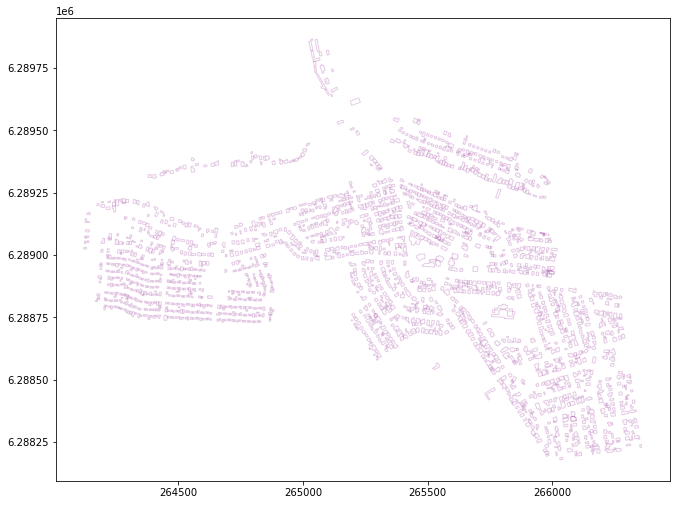

In [16]:
#%matplotlib

fig, ax = plt.subplots(figsize=(11, 11))

ts_copy.plot(ax=ax, facecolor='none', edgecolor='purple', alpha=0.2)
if len(new_df1) > 0:
    new_df1.plot(ax=ax, edgecolor='red', facecolor='none')#, alpha=0.3)#, column='osm_building', legend=True)

#-- save
plt.savefig('./data/topologyFig', dpi=300)
#plt.show()

|  |  |
|:--------:|:--------:|
|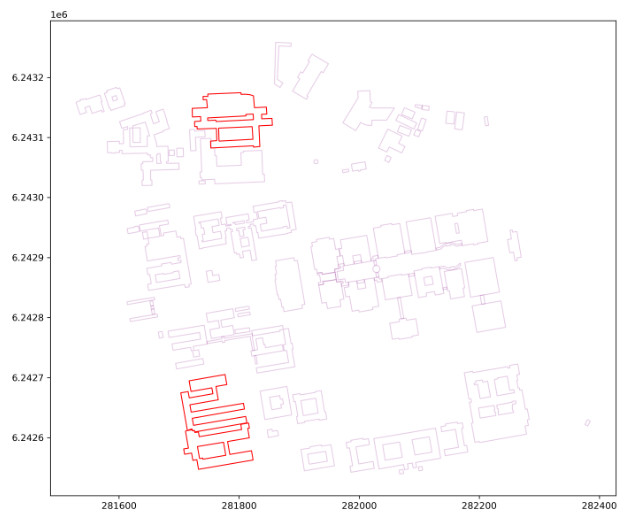 | **Challenges will be highlight in *Red*.**|
|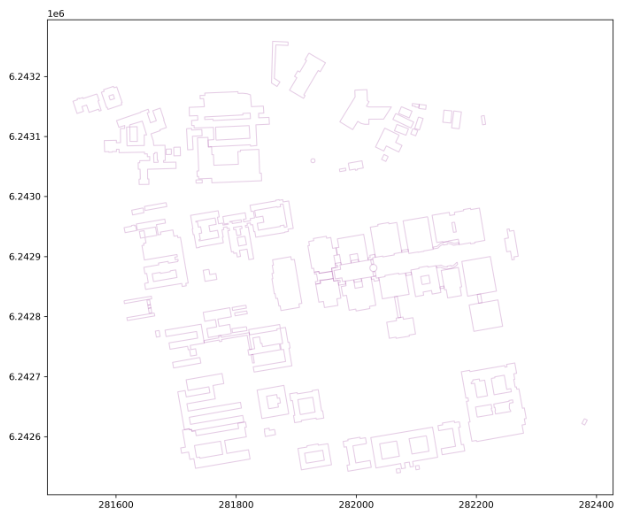 | **or none**|
|<br /> **If you continue without fixing the challenges, the LoD1 City Model *will not be error free*.** | <br /> **Our goal is a topologically correct surface.** |

<h2><center>Please ensure the quality of the value-added product and the source data.</center></h2>

**If necessary; edit [OpenStreetMap](https://www.openstreetmap.org/about) and fix the challenge please.**

<div class="alert alert-block alert-success"><b></b>
    
*And remember; give the OpenStreetMap server at **least a day** before attempting to work through this Notebook again.*  
*Alchemy is a process. **Please be patient**.*
</div>

In [17]:
#- get the mean height of the bld
ts['mean'] = ts.apply(lambda row: rasterQuery(row.geometry, gt_forward, rb), axis = 1)
ts.head(2)

,geometry,type,id,tags,bld,mean
0,"POLYGON ((265041.635 6289775.059, 265050.531 6...",way,328118446,"{'building': 'yes', 'building:levels': '1'}",yes,179.429993
1,"POLYGON ((265070.977 6289761.325, 265072.315 6...",way,328118447,"{'addr:city': 'Cape Town', 'addr:postcode': '7...",church,179.039993


In [18]:
# -- execute function. write geoJSON
city3D.writegjson(ts, jparams)

In [19]:
from shapely.geometry import polygon
import math

start = time.time()

dis = gpd.read_file(jparams['osm_bldings'])                   
dis.set_crs(epsg=int(jparams['crs'][-5:]), inplace=True, allow_override=True)

dict_vertices = {}
cols = [c for c in ['bottom_bridge_height', 'bottom_roof_height', 'roof_height'] if c in dis.columns]

dis['geometry'] = dis.geometry.apply(polygon.orient, 1)

for i, row in dis.iterrows():
    oring = list(row.geometry.exterior.coords)
    name = row['osm_id']
    for (j, v) in enumerate(oring[:-1]):
        vertex = (oring[j][0], oring[j][1])
        attr = [row[c] for c in cols]
        attr = [x for x in attr if not np.isnan(x)]  # Remove np.nan values
        if vertex in dict_vertices.keys():
            dict_vertices[vertex][row['osm_id']] = attr
        else:
            dict_vertices[vertex] = {row['osm_id']: attr}

result = {}
for k1, d in dict_vertices.items():
    for k2 in d:
        result.setdefault(k2, {})[k1] = sorted(list(set([j for i in d.values() for j in i])))
        
dis.drop(dis.index[dis['osm_building'] == 'bridge'], inplace = True)
dis.drop(dis.index[dis['osm_building'] == 'roof'], inplace = True)

#- create a point representing the hole within each building  
dis['x'] = dis.representative_point().x
dis['y'] = dis.representative_point().y
hs = dis[['x', 'y', 'ground_height']].copy()

end = time.time()
print('runtime:', str(timedelta(seconds=(end - start))))

runtime: 0:00:01.302276


In [20]:
dis.head(2)

,osm_id,osm_abandoned,osm_building,osm_address,osm_amenity,osm_area,osm_brand,osm_building:levels,osm_building:part,osm_building:prefabricated,osm_building:use,osm_contact:email,osm_contact:phone,osm_denomination,osm_description,osm_healthcare,osm_healthcare:speciality,osm_heritage,osm_heritage:website,osm_historic,osm_information,osm_internet_access,osm_layer,osm_man_made,osm_name,osm_name:af,osm_name:en,osm_office,osm_opening_date,osm_opening_hours,osm_operator,osm_operator:short,osm_operator:type,osm_operator:wikidata,osm_phone,osm_religion,osm_residential,osm_school,osm_shop,osm_start_date,osm_street_vendor,osm_telecom,osm_tourism,osm_townhall:type,osm_type,osm_watermill:disused,osm_website,footprint,plus_code,ground_height,bottom_roof_height,building_height,roof_height,geometry,x,y
0,328118446,NaN,yes,,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{'type': 'Polygon', 'coordinates': [[[265041.6...",4FRWFFVC+P79,179.43,NaN,4.1,183.53,"POLYGON ((265041.635 6289775.059, 265050.531 6...",265054.096888,6.289783e+06
1,328118447,NaN,church,Kerk Street Mamre 7347 Cape Town,place_of_worship,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN,moravian,NaN,NaN,NaN,building,NaN,NaN,NaN,NaN,NaN,NaN,Mamre Moravian Church,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,christian,NaN,NaN,NaN,1818,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{'type': 'Polygon', 'coordinates': [[[265070.9...",4FRWFFVC+H9Q,179.04,NaN,6.9,185.94,"POLYGON ((265070.977 6289761.325, 265072.315 6...",265078.953745,6.289748e+06


**prepare the elevation for the TIN**

In [21]:
#- 
dis_c = dis.copy()

In [22]:
#- prepare xyz (more buildings = more time)
start = time.time()

df = pd.read_csv(jparams['xyz'],                                      
                 delimiter = ' ', header=None, names=["x", "y", "z"])
    
geometry = [Point(xy) for xy in zip(df.x, df.y)]
gdf = gpd.GeoDataFrame(df, crs=jparams['crs'], geometry=geometry)                    
    
_symdiff = gpd.overlay(aoibuffer, dis_c, keep_geom_type=False, how='symmetric_difference') 
_mask = gdf.within(_symdiff.loc[0, 'geometry'])
gdf = gdf.loc[_mask]
gdf = gdf[gdf['z'] != jparams['nodata']]                              
gdf.reset_index(drop=True, inplace=True)
gdf = gdf.round(2)

end = time.time()
print('runtime:', str(timedelta(seconds=(end - start))))

runtime: 0:02:10.409399


**harvest the segments from the buildings**

In [23]:
#- blds
start = time.time()

all_coords = []
min_zbld = []
dps = 3
segs = set()

dis['geometry'] = dis.geometry.apply(polygon.orient, 1)

def rasterQuery2(mx, my, gt_forward, rb):
    
    px = int((mx - gt_forward[0]) / gt_forward[1])
    py = int((my - gt_forward[3]) / gt_forward[5])

    intval = rb.ReadAsArray(px, py, 1, 1)

    return intval[0][0]

for ids, row in dis.iterrows():
    oring = list(row.geometry.exterior.coords)
    coords_rounded = [(round(x, dps), round(y, dps), round(float(rasterQuery2(x, y, gt_forward, rb)), 2)) for x, y in oring]
    all_coords.extend(coords_rounded)
    zbld = [z for x, y, z in coords_rounded]
    min_zbld.append(min(zbld))
    
    segs.update({(x1, y1, x2, y2) if (x1 < x2) else (x2, y2, x1, y1) for (x1, y1, z1), (x2, y2, z2) in zip(coords_rounded[:-1], coords_rounded[1:])})
    
    for interior in row.geometry.interiors:
        oring = list(interior.coords)
        coords_rounded = [(round(x, dps), round(y, dps), round(float(rasterQuery2(x, y, gt_forward, rb)), 2)) for x, y in oring]
        all_coords.extend(coords_rounded)
        
        segs.update({(x1, y1, x2, y2) if (x1 < x2) else (x2, y2, x1, y1) for (x1, y1, z1), (x2, y2, z2) in zip(coords_rounded[:-1], coords_rounded[1:])})

c = pd.DataFrame.from_dict({"coords": list(segs)}).groupby("coords").size().reset_index(name="count")

ac = pd.DataFrame(all_coords, 
                  columns=["x", "y", "z"]).sort_values(by="z", ascending=False).drop_duplicates(subset=["x", "y"]).reset_index(drop=True)

In [24]:
df2 = pd.concat([gdf, ac])

In [25]:
idx = []
l = len(gdf)
    
for i, row in c.iterrows():
    frx, fry = row.coords[0], row.coords[1]
    tox, toy = row.coords[2], row.coords[3]

    [index_f] = (ac[(ac['x'] == frx) & (ac['y'] == fry)].index.values)
    [index_t] = (ac[(ac['x'] == tox) & (ac['y'] == toy)].index.values)
    idx.append([l + index_f, l + index_t])

**harvest the segments from the aoi**

In [26]:
#- aoi
aoi_coords = []
dps = 3
segs = set()

for ids, row in aoibuffer.iterrows():
    oring = list(row.geometry.exterior.coords)
    coords_rounded = [(round(x, dps), round(y, dps), round(float(rasterQuery2(x, y, gt_forward, rb)), 2)) for x, y in oring]
    aoi_coords.extend(coords_rounded)
    
    segs.update({(x1, y1, x2, y2) if (x1 < x2) else (x2, y2, x1, y1) for (x1, y1, z1), (x2, y2, z2) in zip(coords_rounded[:-1], coords_rounded[1:])})
    
    for interior in row.geometry.interiors:
        oring = list(interior.coords)
        coords_rounded = [(round(x, dps), round(y, dps), round(float(rasterQuery2(x, y, gt_forward, rb)), 2)) for x, y in oring]
        aoi_coords.extend(coords_rounded)
        
        segs.update({(x1, y1, x2, y2) if (x1 < x2) else (x2, y2, x1, y1) for (x1, y1, z1), (x2, y2, z2) in zip(coords_rounded[:-1], coords_rounded[1:])})

ca = pd.DataFrame.from_dict({"coords": list(segs)}).groupby("coords").size().reset_index(name="count")

acoi = pd.DataFrame(aoi_coords, 
                  columns=["x", "y", "z"]).sort_values(by="z", ascending=False).drop_duplicates(subset=["x", "y"]).reset_index(drop=True)

In [27]:
l = len(df2)
#lr = 0
#idx01 = []
 
for i, row in ca.iterrows():
    frx, fry = row.coords[0], row.coords[1]
    tox, toy = row.coords[2], row.coords[3]

    [index_f] = (acoi[(acoi['x'] == frx) & (acoi['y'] == fry)].index.values)
    [index_t] = (acoi[(acoi['x'] == tox) & (acoi['y'] == toy)].index.values)
    idx.append([l + index_f, l + index_t])

In [28]:
df3 = pd.concat([df2, acoi])

**Triangle**

In [29]:
pv_pts = df3[['x', 'y', 'z']].values

In [30]:
pts = df3[['x', 'y']].values 
A = dict(vertices=pts)
Tr = tr.triangulate(A)

In [31]:
holes01 = hs[['x', 'y']].round(3).values.tolist()
pts = df3[['x', 'y']].values #, 'z']].values

#the terrain without the blds
A = dict(vertices=pts, segments=idx, holes=holes01)

Tr = tr.triangulate(A)                  
terrTin = Tr.get('triangles').tolist()

**CityJSON**

In [32]:
#- 
minz = df3['z'].min()
maxz = df3['z'].max()

In [33]:
# -- execute function. create CityJSON
city3D.output_cityjson(extent, minz, maxz, terrTin, pv_pts, jparams, min_zbld, acoi, result) 

In [34]:
src_ds = None

<div class="alert alert-block alert-info"><b></b> 

**Go over to [Ninja the online CityJSON viewer](https://ninja.cityjson.org/#) and explore!**

</div>

**You are welcome to further investigate the quality of a 3D Model.**

**The [val3dity](http://geovalidation.bk.tudelft.nl/val3dity/) web app will test CityJSON geometric primitives.**

If you parse the result of this notebook through [val3dity](http://geovalidation.bk.tudelft.nl/val3dity/) it will return a report: **100% valid!<sup>*</sup>**

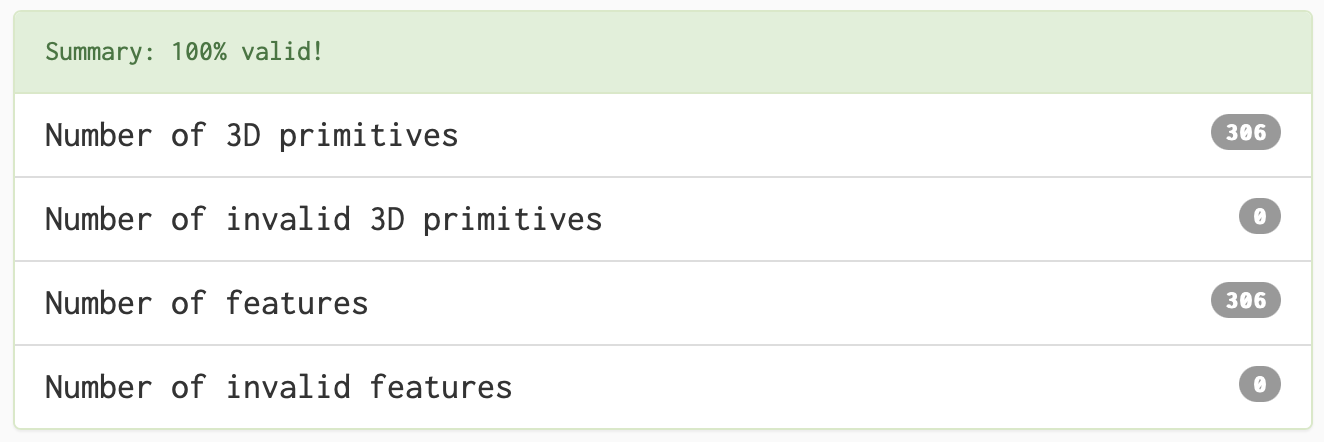

<sup>* *your model conforms to the ISO 19107 standard [connecting and planar surfaces, correct orientation of the surfaces and watertight volumes]*

<div class="alert alert-block alert-warning"><b>NOW</b><br><br>


***To understand the value and usefulness of a 3D City Model***; parse the result of this Notebook through [CityJSONspatialDataScience.ipynb](https://github.com/AdrianKriger/geo3D/blob/main/CityJSONspatialDataScience.ipynb) to workthrough an example of:  
- population estimation and
- a calculation of [Building Volume per Capita]((https://www.researchgate.net/publication/343185735_Building_Volume_Per_Capita_BVPC_A_Spatially_Explicit_Measure_of_Inequality_Relevant_to_the_SDGs)
</div>

***As always; you are welcome to raise an issue. I depend on you to help me improve.***